In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [8]:
# Data loading
path = r'../data/interim/data_v2_English.csv'
alzheimer_df = pd.read_csv(path)
alzheimer_df.head()

,Year,Week,Date,Entity,Epi_Year,M,F,New_Cases_Week
0,2014,2,2014-01-13,Aguascalientes,2014,0.0,0.0,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0,0.0,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0,0.0,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0,0.0,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0,0.0,0.0


## Study of inconsistencies

In [9]:
# Step 0: Create a working copy for consistency checks
alzheimer_check_df = alzheimer_df.copy()

# Step 1: Calculate cumulative sum of H and M
alzheimer_check_df['Current_MF_Sum'] = alzheimer_check_df['M'] + alzheimer_check_df['F']
alzheimer_check_df['Previous_MF_Sum'] = alzheimer_check_df.groupby('Entity')['Current_MF_Sum'].shift(1)

# Step 2: Compute the difference
alzheimer_check_df['Calculated_Difference'] = (
    alzheimer_check_df['Current_MF_Sum'] - alzheimer_check_df['Previous_MF_Sum']
)

# Step 3: Create a flag for week 2 (reset of cumulative values)
alzheimer_check_df['Its_Reset'] = alzheimer_check_df['Week'] == 2

# Step 4: For week 2, the expected difference equals the current cumulative sum
alzheimer_check_df.loc[
    alzheimer_check_df['Its_Reset'], 'Calculated_Difference'
] = alzheimer_check_df['Current_MF_Sum']

# Step 5: Verify consistency with a small tolerance
alzheimer_check_df['Consistent'] = (
    abs(alzheimer_check_df['Calculated_Difference'] - alzheimer_check_df['New_Cases_Week']) < 0.001
)

# Step 6: Filter inconsistencies (excluding the first week of each entity)
alzheimer_inconsistencias_df = alzheimer_check_df[
    ~alzheimer_check_df['Consistent'] &
    alzheimer_check_df['Previous_MF_Sum'].notna()
].copy()

# Step 7: Keep only relevant columns
columns_to_keep = ['Entity', 'Year', 'Week', 'Epi_Year', 'Week', 'M', 'F', 'New_Cases_Week', 'Calculated_Difference']
alzheimer_inconsistencias_df = alzheimer_inconsistencias_df[columns_to_keep]

# Step 8: Summary
total_checked = alzheimer_check_df['Previous_MF_Sum'].notna().sum()
total_inconsistent = len(alzheimer_inconsistencias_df)

print(f"Total records checked: {total_checked}")
print(f"Inconsistencies found: {total_inconsistent}")

Total records checked: 18272
Inconsistencies found: 695


In [10]:
alzheimer_inconsistencias_df.head(10)

,Entity,Year,Week,Epi_Year,Week,M,F,New_Cases_Week,Calculated_Difference
42,Aguascalientes,2014,44,2014,44,2.0,4.0,0.0,1.0
82,Aguascalientes,2015,31,2015,31,2.0,7.0,0.0,1.0
95,Aguascalientes,2015,44,2015,44,3.0,9.0,0.0,-1.0
112,Aguascalientes,2016,9,2016,9,1.0,5.0,0.0,2.0
119,Aguascalientes,2016,16,2016,16,4.0,8.0,0.0,2.0
122,Aguascalientes,2016,19,2016,19,5.0,9.0,0.0,1.0
123,Aguascalientes,2016,20,2016,20,17.0,18.0,1.0,21.0
124,Aguascalientes,2016,21,2016,21,5.0,9.0,0.0,-21.0
125,Aguascalientes,2016,22,2016,22,6.0,11.0,2.0,3.0
136,Aguascalientes,2016,33,2016,33,13.0,21.0,1.0,3.0


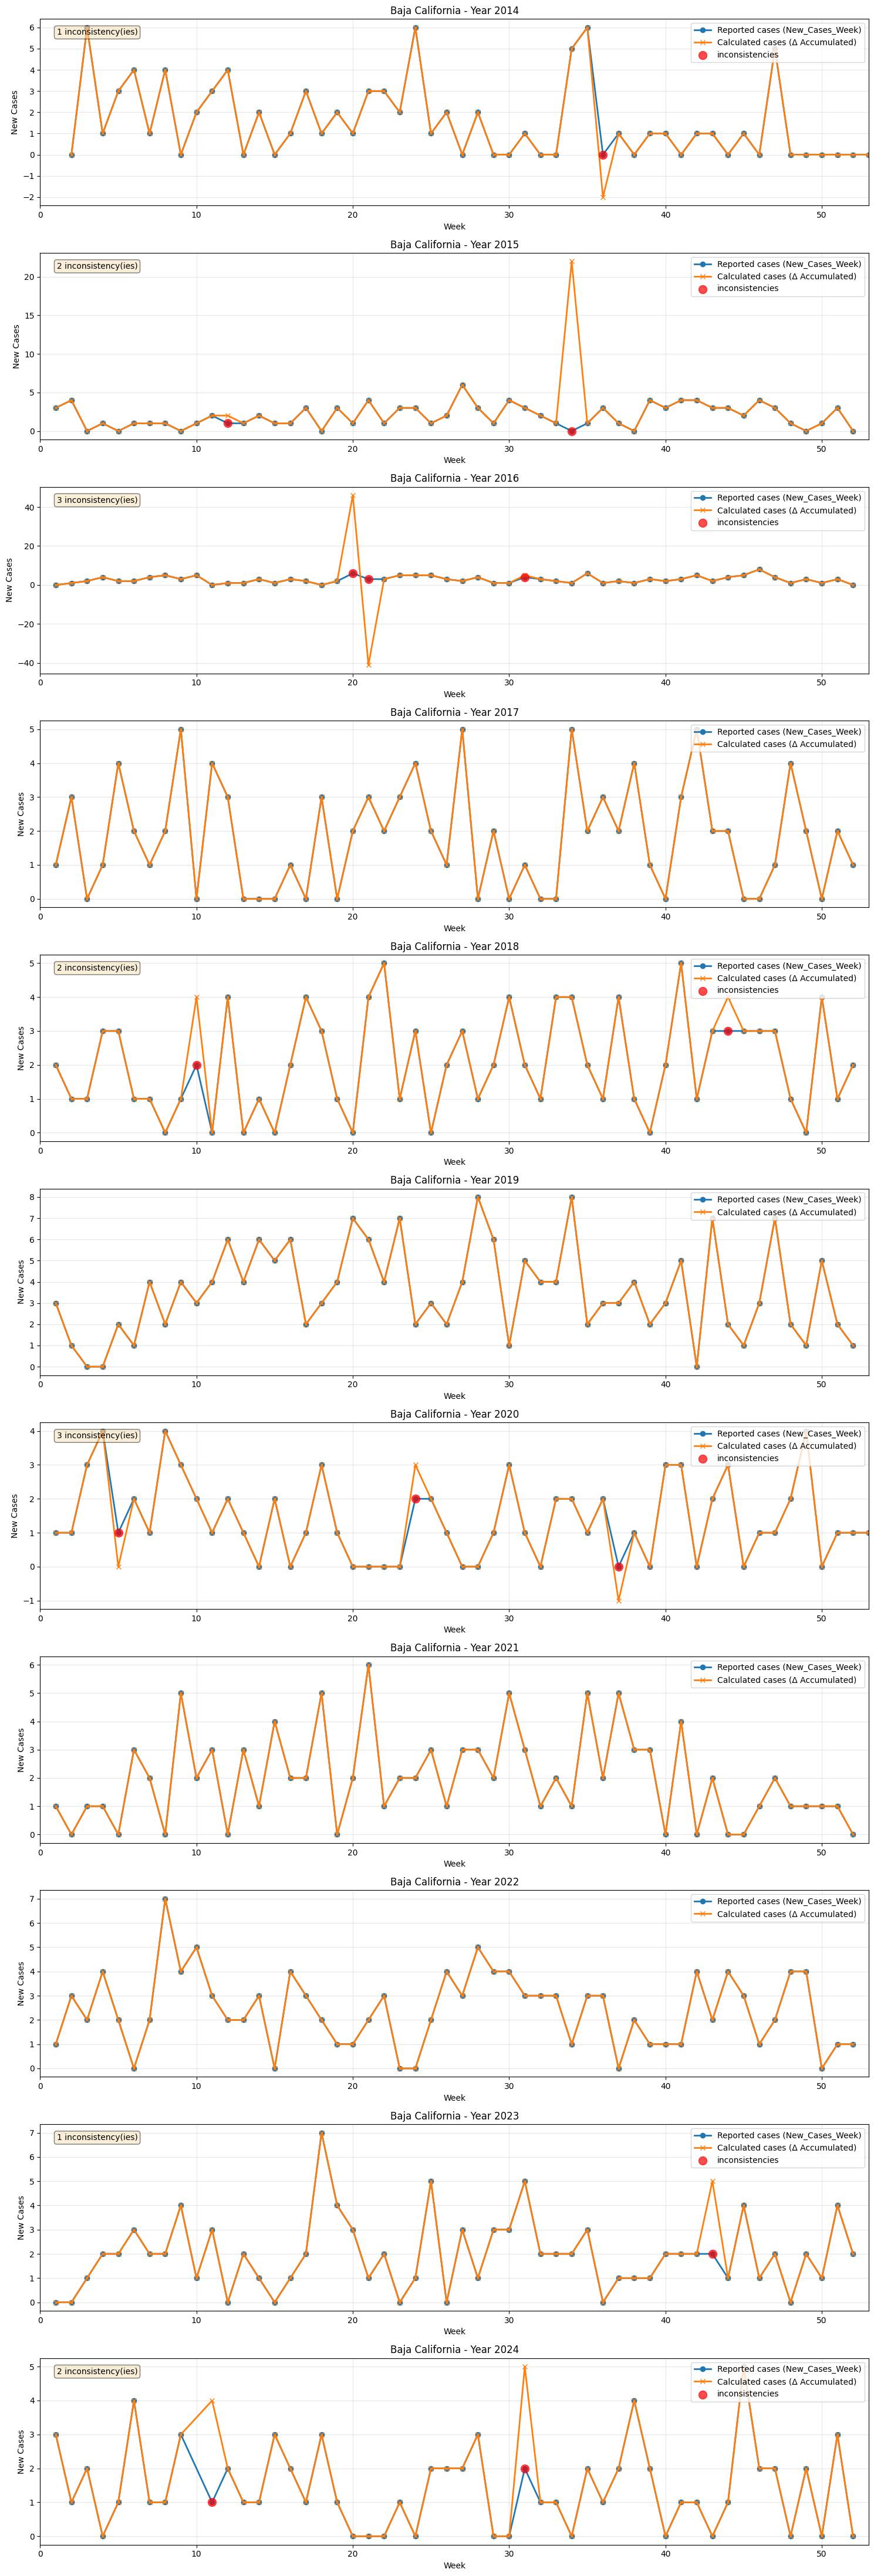

In [12]:
# Step 8: Plot comparison per entity and year
entity = 'Baja California'  # change as needed
df_entity = alzheimer_check_df[alzheimer_check_df['Entity'] == entity].copy()
years = sorted(df_entity['Year'].unique())
n_years = len(years)

fig, axes = plt.subplots(n_years, 1, figsize=(15, 4 * n_years))
if n_years == 1:
    axes = [axes]

for idx, year in enumerate(years):
    df_year = df_entity[df_entity['Year'] == year].copy()
    ax = axes[idx]

    # Plot both lines: reported vs calculated
    ax.plot(df_year['Week'], df_year['New_Cases_Week'], label='Reported cases (New_Cases_Week)', marker='o', linewidth=2)
    ax.plot(df_year['Week'], df_year['Calculated_Difference'], label='Calculated cases (Δ Accumulated)', marker='x', linewidth=2)

    # Highlight inconsistencies
    differences = abs(df_year['New_Cases_Week'] - df_year['Calculated_Difference']) > 0.001
    if differences.any():
        ax.scatter(df_year.loc[differences, 'Week'], df_year.loc[differences, 'New_Cases_Week'],
                   color='red', s=100, zorder=5, label='inconsistencies', alpha=0.7)
        n_incon = differences.sum()
        ax.text(0.02, 0.95, f'{n_incon} inconsistency(ies)',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Aesthetics
    ax.set_xlabel('Week')
    ax.set_ylabel('New Cases')
    ax.set_title(f'{entity} - Year {year}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 53)

plt.tight_layout()
plt.show()


In [ ]:
# output_folder = '../data/interim/'
# filename = 'data_inconsistencies.csv'
# route = os.path.join(output_folder, filename)


# alzheimer_inconsistencias_df.to_csv(
#     route,
#     index=False,
#     encoding='utf-8'
# )

print(alzheimer_inconsistencias_df.info())
alzheimer_inconsistencias_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 42 to 17856
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Entity                 695 non-null    object 
 1   Year                   695 non-null    int64  
 2   Week                   695 non-null    int64  
 3   Epi_Year               695 non-null    int64  
 4   Week                   695 non-null    int64  
 5   M                      695 non-null    float64
 6   F                      695 non-null    float64
 7   New_Cases_Week         695 non-null    float64
 8   Calculated_Difference  695 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 54.3+ KB
None


,Entity,Year,Week,Epi_Year,Week,M,F,New_Cases_Week,Calculated_Difference
42,Aguascalientes,2014,44,2014,44,2.0,4.0,0.0,1.0
82,Aguascalientes,2015,31,2015,31,2.0,7.0,0.0,1.0
95,Aguascalientes,2015,44,2015,44,3.0,9.0,0.0,-1.0
112,Aguascalientes,2016,9,2016,9,1.0,5.0,0.0,2.0
119,Aguascalientes,2016,16,2016,16,4.0,8.0,0.0,2.0
